# Summary Notebook

This research aims to find an answer to three objectives:
1. What are the most important internal and external features in predicting rental prices?
2. What are the top 10 suburbs with the highest predicted growth rate?
3. What are the most liveable and affordable suburbs according to your chosen metrics?


In [2]:
from IPython import display

# Data Downloading

## Methodology

We extracted data from Domain.com using web scraping techniques. To circumvent pagination issues, we integrated postcodes directly into the URL. This approach ensured we achieved comprehensive coverage of properties throughout Victoria. In total, we scraped data for 12,014 properties.

We also sourced external datasets that include census data, population projections, offence counts, and historical rent reports. These were obtained from the Australian Bureau of Statistics (ABS), the Australian Institute of Health and Welfare, the Crime Statistics Agency, and Homes Victoria, respectively.

Additionally, we used Open Route Service to calculate proximities.

# Data Preprocessing & Aggregation

## Properties data
We checked the consistency of the 'rent' column in the properties dataset. Properties with zero values in either the 'beds' or 'baths' columns were removed. Outliers were manually inspected, and after preprocessing, 11,541 properties remained. Subsequently, we determined the median property for each LGA area to represent its entirety.

## Historical rent data
Historical rent data is available for each season annually. As our data was scraped in September, we used the September figures as representative.

## Census data
We sourced census data from 2016 and 2021, extracting the weekly income for each LGA area.

## Offence Count
Offence Count data was categorized by year and LGA regions.

## Population data
The initial population data was based on the SA2 level. We first realigned it to the LGA level, and then merged this adjusted data with the properties dataset.

## Finding Proximities
To prevent the API use restrictions, we set up open route service in docker to find out the proximities to various facilities.

## Missing Values
We found that the population data for Queenscliffe is missing, the Queenscliffe is excluded in our modelling step.

# Limitations and Assumptions
While examining the 'rent' column, we found that some rent values were recorded either annually or monthly. Given the column's string format, we used Regex for identification. Although this approach was largely effective, it wasn't foolproof. Any remaining unidentified entries underwent manual inspection.

When mapping between SA2 and LGA regions, if an SA2 district covered multiple LGAs, we opted for the largest LGA for our analysis.

For proximities, we assume that they remain constant throught different years.

For the weekly income data in each LGA area, recorded only in 2016 and 2021, we made an assumption: the weekly income increased linearly year by year.

In the absence of predictions for future offence counts (2024 - 2026), we utilized a Random Forest algorithm to project the offence count for the subsequent three years.

For some of the dataset such as Offence Count data, they are recorded in xlsx format. To ensure that they can be read in and processed properly, we manually deleted some of the irrelevant rows such as header or instructions.

# Choice of Granularity

Historical rent data is accessible at the LGA level, but not for SA2. Opting for LGA not only facilitates the use of this historical data but also enhances the accuracy of our predictions.

Additionally, the general public and potential renters are likely more acquainted with LGA names and boundaries compared to SA2 divisions. As a result, predictions grounded in LGAs might resonate better and be more intuitive for them.

# Feature Importance
We inspect the feature importance of features that make a property more expensive, the result is below. It turns out that the distrance to CBD and number of beds or baths make a property more expensive.

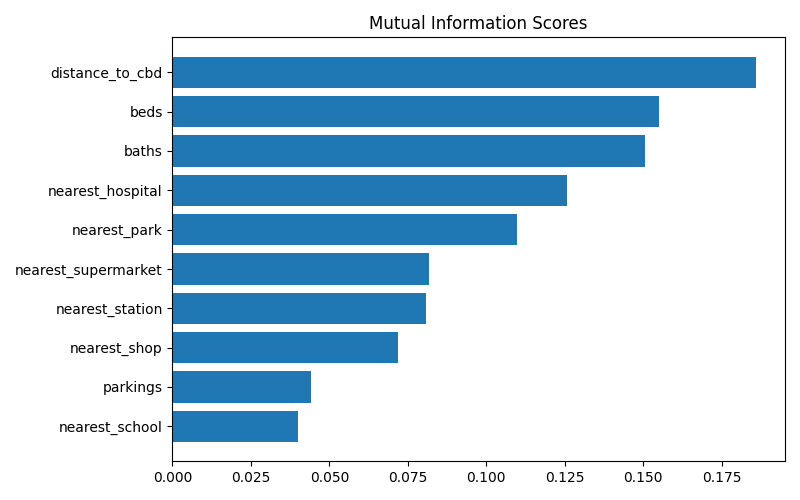

In [3]:
display.Image("../plots/feature_importance.png")

# Modelling

## Preprocessing
The dataset we utilized for prediction contains the following columns:
lga_name, cost, beds, baths, parkings, nearest_station, nearest_park, nearest_shop, nearest_hospital, nearest_school, nearest_supermarket, distance_to_cbd, year, offence_count, population, and weekly_income.

We applied one-hot encoding to the LGA_NAME column.
Log-transformation was performed on the numerical columns, except for beds, baths, parkings, and year, which were retained in their original form.

## Modelling
We first performed forward selection to fit a linear regression model based on AIC. The report is as below:

The model's R-squared value is 0.871, indicating that approximately 87.1% of the variance in the dependent variable, cost, can be explained by the independent variables in the model. This is a relatively high R-squared value, suggesting that the model fits the data well.

The adjusted R-squared is slightly lower at 0.860, but it's still quite high. The adjusted R-squared takes into account the number of predictors in the model, so this slight decrease is expected when adding more predictors.

The F-statistic is 82.89 with a very low associated probability (p-value of 1.83e-196). This indicates that the model is statistically significant, and the predictors in the model collectively have a significant effect on the dependent variable, cost.

We then split the training dataset into training set (2017-2022) and validation set (2023). We fit a linear regression model using the selected features from forward selection and all features for Random Forests. The linear regression gave a RMSE of 83.4 while the Random Forests gave a RMSE of 97.3.

## Comparison & Analysis:
The linear regression model outperformed the Random Forests model on the validation set, as evidenced by its lower RMSE. This suggests that, for this particular dataset and problem, a linear approach might be more suitable than the ensemble-based Random Forests. It's also worth noting that the feature selection process for the linear regression might have contributed to its superior performance by focusing on the most relevant predictors.

## Predictions
We then fit the linear regression model to the whole training set and calculate the LGAs with highest growth rates.

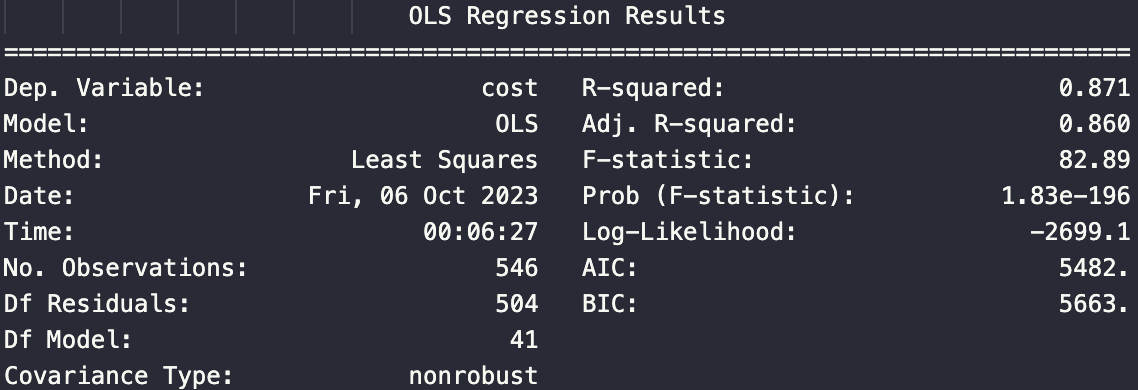

In [2]:
display.Image("../plots/LR report.png")

# Scoring

We engineered a new feature called cirminal rate derived by Offence Count/Population. We then assigned a coefficient to every column to represent the weight of it. Eventrually, we used 
- 'Nearest_park': -0.15,
- 'Nearest_school': -0.15,
- 'Nearest_hospital': -0.15,
- 'Nearest_supermarket': -0.15,
- 'distance_to_cbd': -0.15, 
- 'crime_rate': -0.1,
- 'weekly_income': 0.1

After that, we used minmax scaling to ensure the scores range from 0 to 1.

The result is as below: 

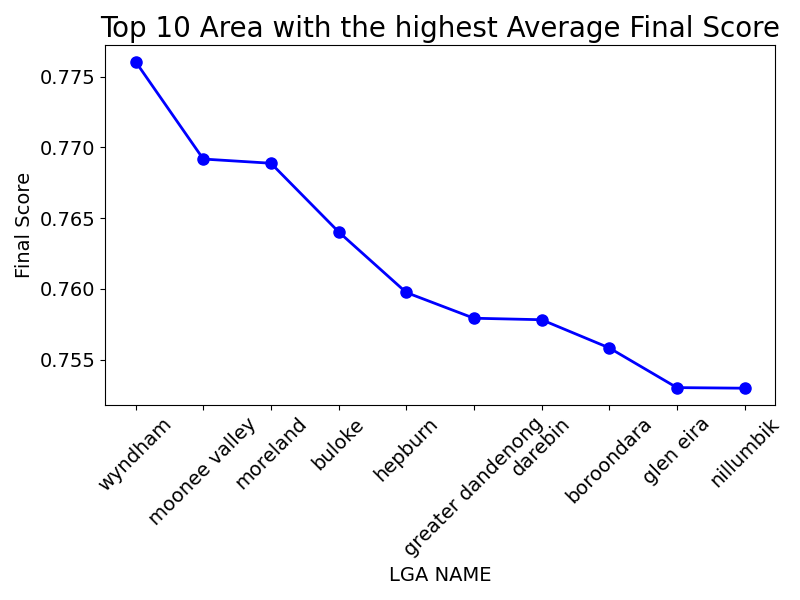

In [6]:
display.Image("../plots/top 10 average score.png")

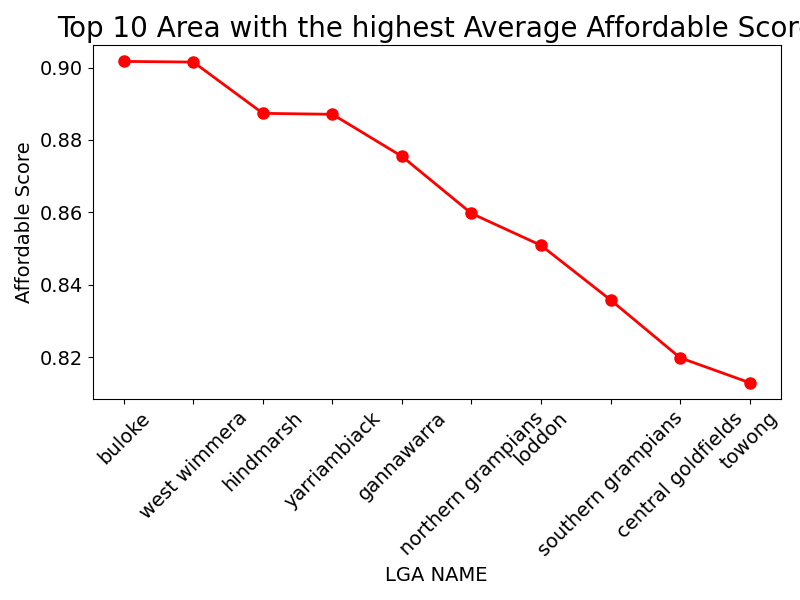

In [7]:
display.Image("../plots/top 10 affordable score.png")

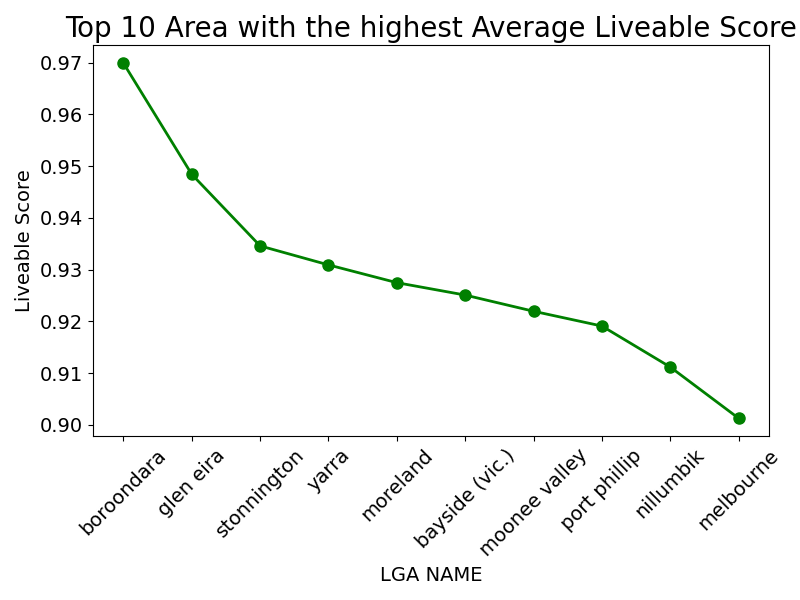

In [4]:
display.Image("../plots/top 10 livable score.png")